# Value-based deep reinforcement learning: Dueling DDQN and PER

## Summary

- Deep RL handles sequential, evaluative and sampled feedback using non-linear function approximation
- In complex environments we have high-dimensional and continuous state and action spaces
- Dueling DDQN: Two separate estimators for state-value and action-advantage function, Polyak Averaging for slowed down updates instead of freezing parameters
- Prioritized experience replay (PER) samples from replay buffer based on rank-based prioritization, proportional prioritization or weighted-importance sampling


### Imports and GPU utilization

In [1]:
!nvidia-smi

Tue May  9 09:48:39 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.46                 Driver Version: 531.61       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 S...    On | 00000000:27:00.0  On |                  N/A |
|  0%   60C    P0               49W / 250W|   1258MiB /  8192MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import warnings ; warnings.filterwarnings('ignore')
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import cycle, count
from textwrap import wrap

import matplotlib
import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import glob
import time
import json
import sys
import gym
import io
import os
import gc

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

LEAVE_PRINT_EVERY_N_SECS = 120
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")
RESULTS_DIR = os.path.join('..', 'results')
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [3]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [4]:
torch.cuda.is_available()

True

### Helper functions

In [5]:
def get_make_env_fn(**kargs):
    def make_env_fn(env_name, seed=None, render=None, record=False,
                    unwrapped=False, monitor_mode=None, 
                    inner_wrappers=None, outer_wrappers=None):
        mdir = tempfile.mkdtemp()
        env = None
        if render:
            try:
                env = gym.make(env_name, render=render)
            except:
                pass
        if env is None:
            env = gym.make(env_name)
        if seed is not None: env.seed(seed)
        env = env.unwrapped if unwrapped else env
        if inner_wrappers:
            for wrapper in inner_wrappers:
                env = wrapper(env)
        env = wrappers.Monitor(
            env, mdir, force=True, 
            mode=monitor_mode, 
            video_callable=lambda e_idx: record) if monitor_mode else env
        if outer_wrappers:
            for wrapper in outer_wrappers:
                env = wrapper(env)
        return env
    return make_env_fn, kargs

In [6]:
def get_videos_html(env_videos, title, max_n_videos=5):
    videos = np.array(env_videos)
    if len(videos) == 0:
        return
    
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)

        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <video width="960" height="540" controls>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [7]:
def get_gif_html(env_videos, title, subtitle_eps=None, max_n_videos=4):
    videos = np.array(env_videos)
    if len(videos) == 0:
        return
    
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        basename = os.path.splitext(video_path)[0]
        gif_path = basename + '.gif'
        if not os.path.exists(gif_path):
            ps = subprocess.Popen(
                ('ffmpeg', 
                 '-i', video_path, 
                 '-r', '7',
                 '-f', 'image2pipe', 
                 '-vcodec', 'ppm',
                 '-crf', '20',
                 '-vf', 'scale=512:-1',
                 '-'), 
                stdout=subprocess.PIPE)
            output = subprocess.check_output(
                ('convert',
                 '-coalesce',
                 '-delay', '7',
                 '-loop', '0',
                 '-fuzz', '2%',
                 '+dither',
                 '-deconstruct',
                 '-layers', 'Optimize',
                 '-', gif_path), 
                stdin=ps.stdout)
            ps.wait()

        gif = io.open(gif_path, 'r+b').read()
        encoded = base64.b64encode(gif)
            
        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <img src="data:image/gif;base64,{1}" />"""
        prefix = 'Trial ' if subtitle_eps is None else 'Episode '
        sufix = str(meta['episode_id'] if subtitle_eps is None \
                    else subtitle_eps[meta['episode_id']])
        strm += html_tag.format(prefix + sufix, encoded.decode('ascii'))
    return strm

## Dueling DDQN

<img src="../blob/img/07_dueling-ddqn.png" alt= “” width="500" height="300">

In [8]:
class FCQ(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])

        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)
        
    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, state):
        x = self._format(state)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x
    
    def numpy_float_to_device(self, variable):
        variable = torch.from_numpy(variable).float().to(self.device)
        return variable
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [9]:
class GreedyStrategy():
    def __init__(self):
        self.exploratory_action_taken = False

    def select_action(self, model, state):
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()
            return np.argmax(q_values)

In [10]:
class EGreedyStrategy():
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self.exploratory_action_taken = None

    def select_action(self, model, state):
        self.exploratory_action_taken = False
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))

        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [11]:
class EGreedyLinearStrategy():
    def __init__(self, init_epsilon=1.0, min_epsilon=0.1, max_steps=20000):
        self.t = 0
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.min_epsilon = min_epsilon
        self.max_steps = max_steps
        self.exploratory_action_taken = None
        
    def _epsilon_update(self):
        epsilon = 1 - self.t / self.max_steps
        epsilon = (self.init_epsilon - self.min_epsilon) * epsilon + self.min_epsilon
        epsilon = np.clip(epsilon, self.min_epsilon, self.init_epsilon)
        self.t += 1
        return epsilon

    def select_action(self, model, state):
        self.exploratory_action_taken = False
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().ipynb_checkpoints/squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))

        self.epsilon = self._epsilon_update()
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [12]:
class EGreedyExpStrategy():
    def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_steps = decay_steps
        self.min_epsilon = min_epsilon
        self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
        self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
        self.t = 0
        self.exploratory_action_taken = None

    def _epsilon_update(self):
        self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
        self.t += 1
        return self.epsilon

    def select_action(self, model, state):
        self.exploratory_action_taken = False
        with torch.no_grad():
            q_values = model(state).detach().cpu().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else:
            action = np.random.randint(len(q_values))

        self._epsilon_update()
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [13]:
class SoftMaxStrategy():
    def __init__(self, 
                 init_temp=1.0, 
                 min_temp=0.3, 
                 exploration_ratio=0.8, 
                 max_steps=25000):
        self.t = 0
        self.init_temp = init_temp
        self.exploration_ratio = exploration_ratio
        self.min_temp = min_temp
        self.max_steps = max_steps
        self.exploratory_action_taken = None
        
    def _update_temp(self):
        temp = 1 - self.t / (self.max_steps * self.exploration_ratio)
        temp = (self.init_temp - self.min_temp) * temp + self.min_temp
        temp = np.clip(temp, self.min_temp, self.init_temp)
        self.t += 1
        return temp

    def select_action(self, model, state):
        self.exploratory_action_taken = False
        temp = self._update_temp()

        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()
            scaled_qs = q_values/temp
            norm_qs = scaled_qs - scaled_qs.max()            
            e = np.exp(norm_qs)
            probs = e / np.sum(e)
            assert np.isclose(probs.sum(), 1.0)

        action = np.random.choice(np.arange(len(probs)), size=1, p=probs)[0]
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [14]:
class ReplayBuffer():
    def __init__(self, 
                 max_size=10000, 
                 batch_size=64):
        self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)

        self.max_size = max_size
        self.batch_size = batch_size
        self._idx = 0
        self.size = 0
    
    def store(self, sample):
        s, a, r, p, d = sample
        self.ss_mem[self._idx] = s
        self.as_mem[self._idx] = a
        self.rs_mem[self._idx] = r
        self.ps_mem[self._idx] = p
        self.ds_mem[self._idx] = d
        
        self._idx += 1
        self._idx = self._idx % self.max_size

        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size

        idxs = np.random.choice(
            self.size, batch_size, replace=False)
        experiences = np.vstack(self.ss_mem[idxs]), \
                      np.vstack(self.as_mem[idxs]), \
                      np.vstack(self.rs_mem[idxs]), \
                      np.vstack(self.ps_mem[idxs]), \
                      np.vstack(self.ds_mem[idxs])
        return experiences

    def __len__(self):
        return self.size

In [15]:
class FCDuelingQ(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(FCDuelingQ, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_value = nn.Linear(hidden_dims[-1], 1)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)
        
    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)      
        return x

    def forward(self, state):
        x = self._format(state)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        a = self.output_layer(x)
        v = self.output_value(x).expand_as(a)
        q = v + a - a.mean(1, keepdim=True).expand_as(a)
        return q

    def numpy_float_to_device(self, variable):
        variable = torch.from_numpy(variable).float().to(self.device)
        return variable

    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [16]:
class DuelingDDQN():
    def __init__(self, 
                 replay_buffer_fn, 
                 value_model_fn, 
                 value_optimizer_fn, 
                 value_optimizer_lr,
                 max_gradient_norm,
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps,
                 tau):
        self.replay_buffer_fn = replay_buffer_fn
        self.value_model_fn = value_model_fn
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        self.max_gradient_norm = max_gradient_norm
        self.training_strategy_fn = training_strategy_fn
        self.evaluation_strategy_fn = evaluation_strategy_fn
        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps
        self.tau = tau

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)

        argmax_a_q_sp = self.online_model(next_states).max(1)[1]
        q_sp = self.target_model(next_states).detach()
        max_a_q_sp = q_sp[
            np.arange(batch_size), argmax_a_q_sp].unsqueeze(1)
        target_q_sa = rewards + (self.gamma * max_a_q_sp * (1 - is_terminals))
        q_sa = self.online_model(states).gather(1, actions)

        td_error = q_sa - target_q_sa
        value_loss = td_error.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()        
        torch.nn.utils.clip_grad_norm_(self.online_model.parameters(), 
                                       self.max_gradient_norm)
        self.value_optimizer.step()

    def interaction_step(self, state, env):
        action = self.training_strategy.select_action(self.online_model, state)
        new_state, reward, is_terminal, info = env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_terminal and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))
        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.training_strategy.exploratory_action_taken)
        return new_state, is_terminal
    
    def update_network(self, tau=None):
        tau = self.tau if tau is None else tau
        for target, online in zip(self.target_model.parameters(), 
                                  self.online_model.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.checkpoint_dir = tempfile.mkdtemp()
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        self.target_model = self.value_model_fn(nS, nA)
        self.online_model = self.value_model_fn(nS, nA)
        self.update_network(tau=1.0)

        self.value_optimizer = self.value_optimizer_fn(self.online_model, 
                                                       self.value_optimizer_lr)

        self.replay_buffer = self.replay_buffer_fn()
        self.training_strategy = training_strategy_fn()
        self.evaluation_strategy = evaluation_strategy_fn() 
                    
        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state, env)
                
                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    experiences = self.online_model.load(experiences)
                    self.optimize_model(experiences)
                
                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_network()

                if is_terminal:
                    gc.collect()
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.online_model, env)
            self.save_checkpoint(episode-1, self.online_model)
            
            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)
            
            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward

            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:06}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
                
        final_eval_score, score_std = self.evaluate(self.online_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        self.get_cleaned_checkpoints()
        return result, final_eval_score, training_time, wallclock_time
    
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.evaluation_strategy.select_action(eval_policy_model, s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)

    def get_cleaned_checkpoints(self, n_checkpoints=5):
        try: 
            return self.checkpoint_paths
        except AttributeError:
            self.checkpoint_paths = {}

        paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
        paths_dic = {int(path.split('.')[-2]):path for path in paths}
        last_ep = max(paths_dic.keys())
        # checkpoint_idxs = np.geomspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1
        checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1

        for idx, path in paths_dic.items():
            if idx in checkpoint_idxs:
                self.checkpoint_paths[idx] = path
            else:
                os.unlink(path)

        return self.checkpoint_paths

    def demo_last(self, title='Fully-trained {} Agent', n_episodes=3, max_n_videos=3):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        last_ep = max(checkpoint_paths.keys())
        self.online_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

        self.evaluate(self.online_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def demo_progression(self, title='{} Agent progression', max_n_videos=5):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        for i in sorted(checkpoint_paths.keys()):
            self.online_model.load_state_dict(torch.load(checkpoint_paths[i]))
            self.evaluate(self.online_model, env, n_episodes=1)

        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            subtitle_eps=sorted(checkpoint_paths.keys()),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(), 
                   os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))

In [17]:
dueling_ddqn_results = []
dueling_ddqn_agents, best_dueling_ddqn_agent_key, best_eval_score = {}, None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 25,
        'max_episodes': 10000,
        'goal_mean_100_reward': 475
    }
    
    # value_model_fn = lambda nS, nA: FCQ(nS, nA, hidden_dims=(512,128))
    value_model_fn = lambda nS, nA: FCDuelingQ(nS, nA, hidden_dims=(512,128))
    value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0005
    max_gradient_norm = float('inf')

    training_strategy_fn = lambda: EGreedyExpStrategy(init_epsilon=1.0,  
                                                      min_epsilon=0.3, 
                                                      decay_steps=20000)
    evaluation_strategy_fn = lambda: GreedyStrategy()

    replay_buffer_fn = lambda: ReplayBuffer(max_size=50000, batch_size=64)
    n_warmup_batches = 5
    update_target_every_steps = 1
    tau = 0.1

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = DuelingDDQN(replay_buffer_fn,
                        value_model_fn,
                        value_optimizer_fn,
                        value_optimizer_lr,
                        max_gradient_norm,
                        training_strategy_fn,
                        evaluation_strategy_fn,
                        n_warmup_batches,
                        update_target_every_steps,
                        tau)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    dueling_ddqn_results.append(result)
    dueling_ddqn_agents[seed] = agent
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_dueling_ddqn_agent_key = seed
dueling_ddqn_results = np.array(dueling_ddqn_results)
_ = BEEP()

el 00:00:02, ep 0000, ts 000016, ar 10 016.0±000.0, 100 016.0±000.0, ex 100 0.3±0.0, ev 009.0±000.0
el 00:02:03, ep 0133, ts 010559, ar 10 184.4±087.8, 100 095.8±080.0, ex 100 0.3±0.1, ev 323.3±099.7
el 00:04:05, ep 0173, ts 022164, ar 10 435.2±101.2, 100 190.2±133.7, ex 100 0.2±0.1, ev 348.4±107.0
el 00:06:09, ep 0199, ts 034289, ar 10 429.8±110.6, 100 292.3±156.3, ex 100 0.2±0.1, ev 395.3±112.4
el 00:08:14, ep 0225, ts 045470, ar 10 434.8±144.3, 100 363.2±152.4, ex 100 0.2±0.0, ev 439.7±098.2
el 00:09:27, ep 0243, ts 052430, ar 10 422.4±124.0, 100 396.7±143.1, ex 100 0.2±0.0, ev 476.8±059.1
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 499.60±3.51 in 503.98s training time, 601.51s wall-clock time.

el 00:00:00, ep 0000, ts 000034, ar 10 034.0±000.0, 100 034.0±000.0, ex 100 0.6±0.0, ev 008.0±000.0
el 00:02:00, ep 0146, ts 010775, ar 10 183.9±071.8, 100 094.5±084.9, ex 100 0.3±0.1, ev 253.5±099.5
el 00:04:00, ep 0191, ts 022812, ar 10 340.3±097.0, 100 197.8±1


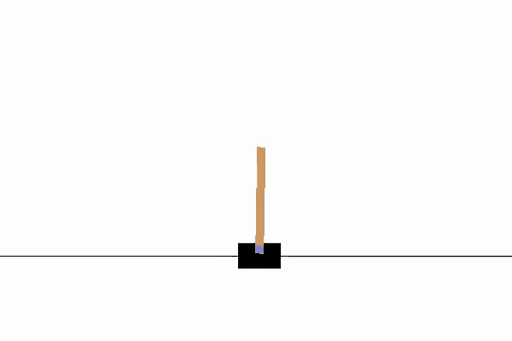
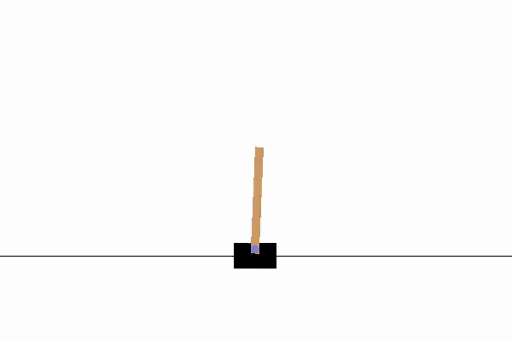
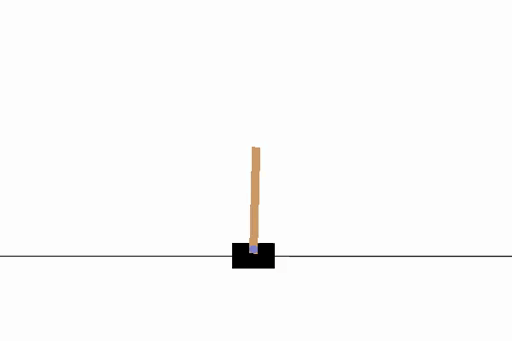
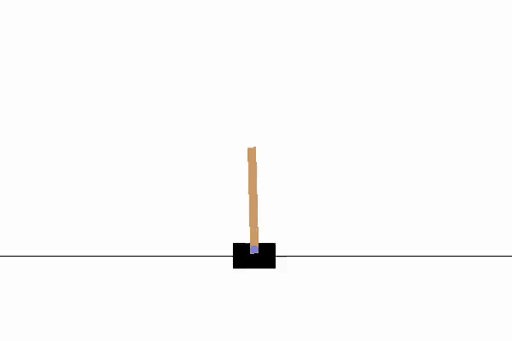
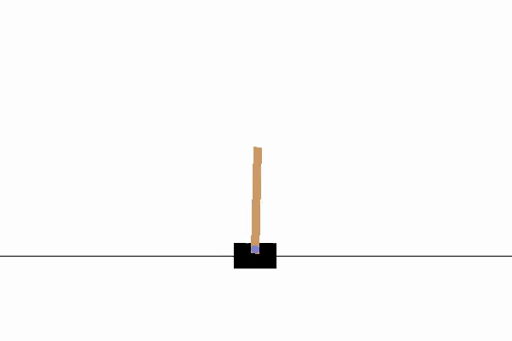

In [18]:
dueling_ddqn_agents[best_dueling_ddqn_agent_key].demo_progression()


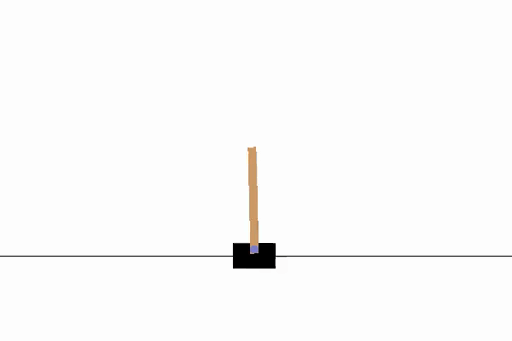
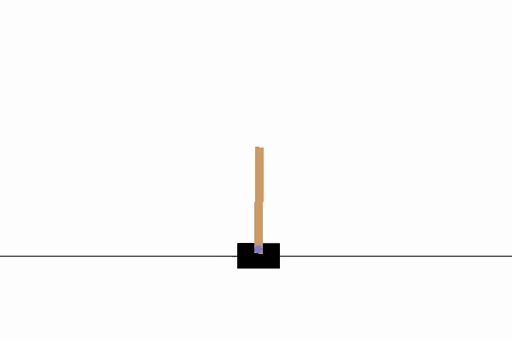
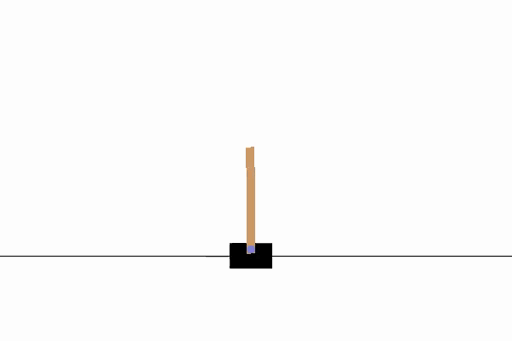

In [19]:
dueling_ddqn_agents[best_dueling_ddqn_agent_key].demo_last()

In [20]:
ddqn_root_dir = os.path.join(RESULTS_DIR, 'ddqn')
ddqn_x = np.load(os.path.join(ddqn_root_dir, 'x.npy'))

ddqn_max_r = np.load(os.path.join(ddqn_root_dir, 'max_r.npy'))
ddqn_min_r = np.load(os.path.join(ddqn_root_dir, 'min_r.npy'))
ddqn_mean_r = np.load(os.path.join(ddqn_root_dir, 'mean_r.npy'))

ddqn_max_s = np.load(os.path.join(ddqn_root_dir, 'max_s.npy'))
ddqn_min_s = np.load(os.path.join(ddqn_root_dir, 'min_s.npy'))
ddqn_mean_s = np.load(os.path.join(ddqn_root_dir, 'mean_s.npy'))

ddqn_max_t = np.load(os.path.join(ddqn_root_dir, 'max_t.npy'))
ddqn_min_t = np.load(os.path.join(ddqn_root_dir, 'min_t.npy'))
ddqn_mean_t = np.load(os.path.join(ddqn_root_dir, 'mean_t.npy'))

ddqn_max_sec = np.load(os.path.join(ddqn_root_dir, 'max_sec.npy'))
ddqn_min_sec = np.load(os.path.join(ddqn_root_dir, 'min_sec.npy'))
ddqn_mean_sec = np.load(os.path.join(ddqn_root_dir, 'mean_sec.npy'))

ddqn_max_rt = np.load(os.path.join(ddqn_root_dir, 'max_rt.npy'))
ddqn_min_rt = np.load(os.path.join(ddqn_root_dir, 'min_rt.npy'))
ddqn_mean_rt = np.load(os.path.join(ddqn_root_dir, 'mean_rt.npy'))

In [21]:
dueling_ddqn_max_t, dueling_ddqn_max_r, dueling_ddqn_max_s, \
dueling_ddqn_max_sec, dueling_ddqn_max_rt = np.max(dueling_ddqn_results, axis=0).T
dueling_ddqn_min_t, dueling_ddqn_min_r, dueling_ddqn_min_s, \
dueling_ddqn_min_sec, dueling_ddqn_min_rt = np.min(dueling_ddqn_results, axis=0).T
dueling_ddqn_mean_t, dueling_ddqn_mean_r, dueling_ddqn_mean_s, \
dueling_ddqn_mean_sec, dueling_ddqn_mean_rt = np.mean(dueling_ddqn_results, axis=0).T
dueling_ddqn_x = np.arange(np.max(
    (len(dueling_ddqn_mean_s), len(ddqn_mean_s))))

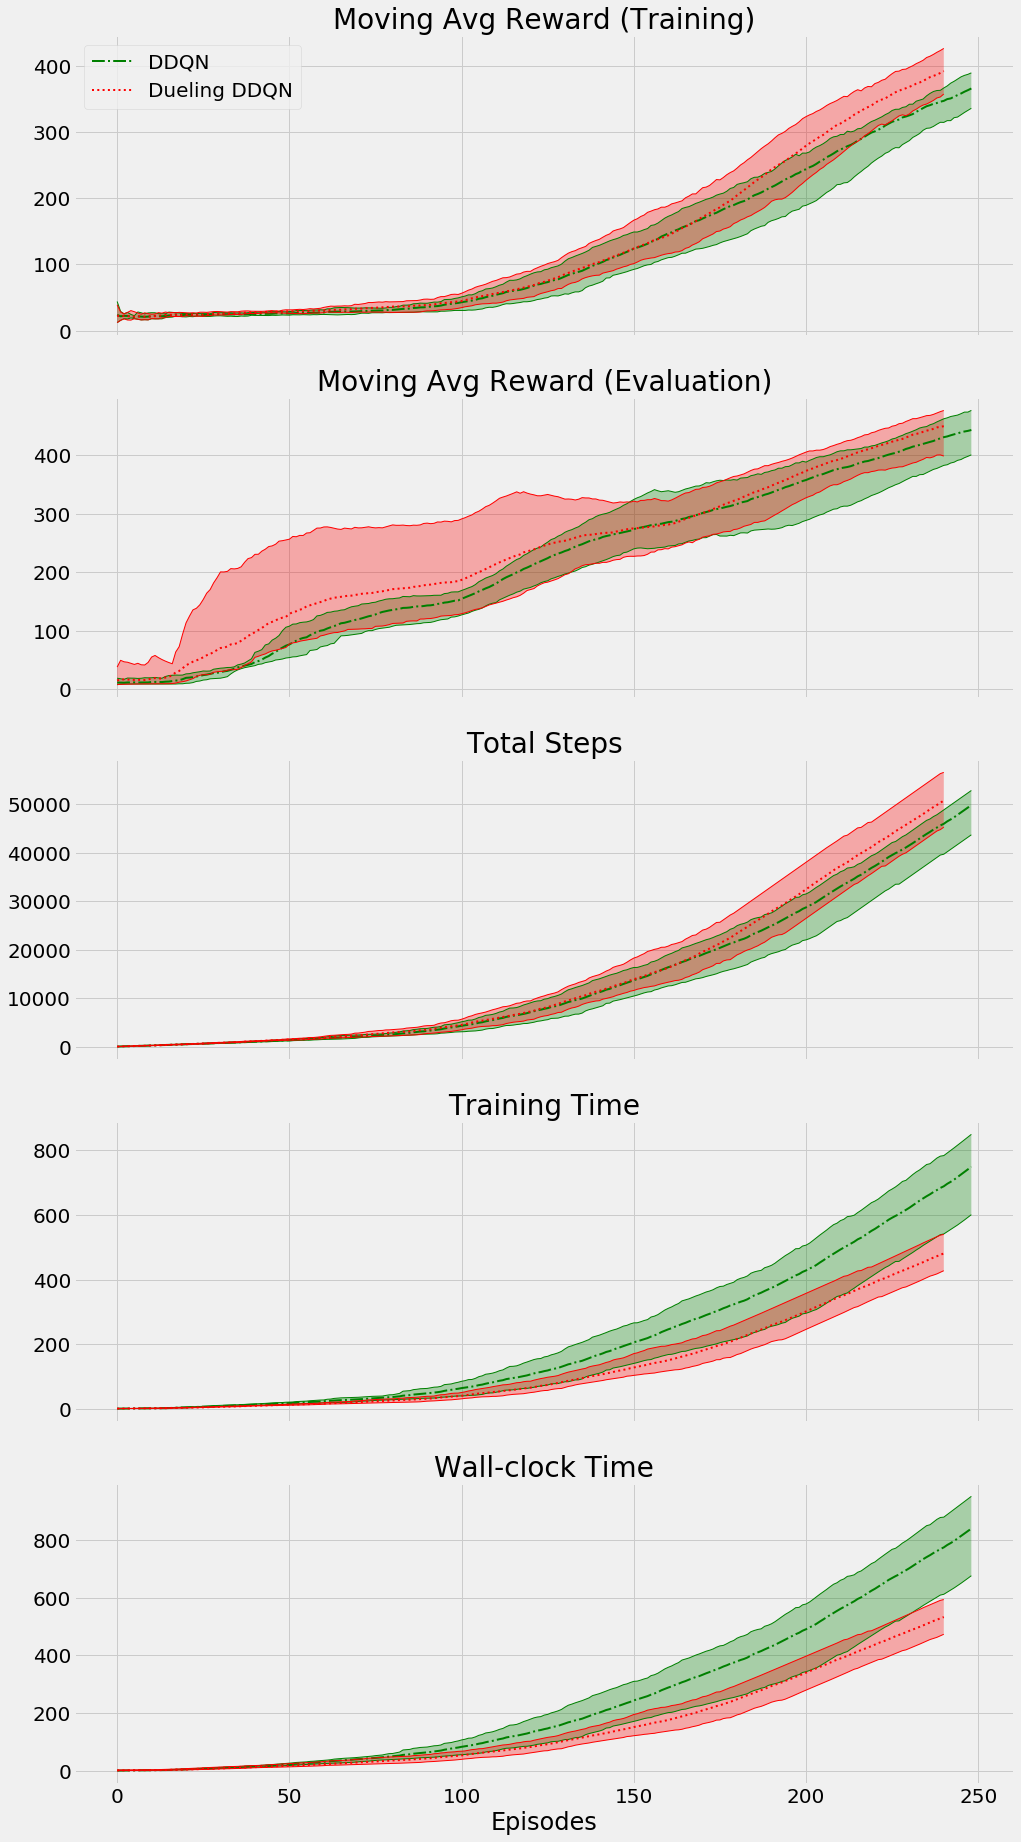

In [22]:
fig, axs = plt.subplots(5, 1, figsize=(15,30), sharey=False, sharex=True)

# DDQN
axs[0].plot(ddqn_max_r, 'g', linewidth=1)
axs[0].plot(ddqn_min_r, 'g', linewidth=1)
axs[0].plot(ddqn_mean_r, 'g-.', label='DDQN', linewidth=2)
axs[0].fill_between(ddqn_x, ddqn_min_r, ddqn_max_r, facecolor='g', alpha=0.3)

axs[1].plot(ddqn_max_s, 'g', linewidth=1)
axs[1].plot(ddqn_min_s, 'g', linewidth=1)
axs[1].plot(ddqn_mean_s, 'g-.', label='DDQN', linewidth=2)
axs[1].fill_between(ddqn_x, ddqn_min_s, ddqn_max_s, facecolor='g', alpha=0.3)

axs[2].plot(ddqn_max_t, 'g', linewidth=1)
axs[2].plot(ddqn_min_t, 'g', linewidth=1)
axs[2].plot(ddqn_mean_t, 'g-.', label='DDQN', linewidth=2)
axs[2].fill_between(ddqn_x, ddqn_min_t, ddqn_max_t, facecolor='g', alpha=0.3)

axs[3].plot(ddqn_max_sec, 'g', linewidth=1)
axs[3].plot(ddqn_min_sec, 'g', linewidth=1)
axs[3].plot(ddqn_mean_sec, 'g-.', label='DDQN', linewidth=2)
axs[3].fill_between(ddqn_x, ddqn_min_sec, ddqn_max_sec, facecolor='g', alpha=0.3)

axs[4].plot(ddqn_max_rt, 'g', linewidth=1)
axs[4].plot(ddqn_min_rt, 'g', linewidth=1)
axs[4].plot(ddqn_mean_rt, 'g-.', label='DDQN', linewidth=2)
axs[4].fill_between(ddqn_x, ddqn_min_rt, ddqn_max_rt, facecolor='g', alpha=0.3)

# Dueling DDQN
axs[0].plot(dueling_ddqn_max_r, 'r', linewidth=1)
axs[0].plot(dueling_ddqn_min_r, 'r', linewidth=1)
axs[0].plot(dueling_ddqn_mean_r, 'r:', label='Dueling DDQN', linewidth=2)
axs[0].fill_between(
    dueling_ddqn_x, dueling_ddqn_min_r, dueling_ddqn_max_r, facecolor='r', alpha=0.3)

axs[1].plot(dueling_ddqn_max_s, 'r', linewidth=1)
axs[1].plot(dueling_ddqn_min_s, 'r', linewidth=1)
axs[1].plot(dueling_ddqn_mean_s, 'r:', label='Dueling DDQN', linewidth=2)
axs[1].fill_between(
    dueling_ddqn_x, dueling_ddqn_min_s, dueling_ddqn_max_s, facecolor='r', alpha=0.3)

axs[2].plot(dueling_ddqn_max_t, 'r', linewidth=1)
axs[2].plot(dueling_ddqn_min_t, 'r', linewidth=1)
axs[2].plot(dueling_ddqn_mean_t, 'r:', label='Dueling DDQN', linewidth=2)
axs[2].fill_between(
    dueling_ddqn_x, dueling_ddqn_min_t, dueling_ddqn_max_t, facecolor='r', alpha=0.3)

axs[3].plot(dueling_ddqn_max_sec, 'r', linewidth=1)
axs[3].plot(dueling_ddqn_min_sec, 'r', linewidth=1)
axs[3].plot(dueling_ddqn_mean_sec, 'r:', label='Dueling DDQN', linewidth=2)
axs[3].fill_between(
    dueling_ddqn_x, dueling_ddqn_min_sec, dueling_ddqn_max_sec, facecolor='r', alpha=0.3)

axs[4].plot(dueling_ddqn_max_rt, 'r', linewidth=1)
axs[4].plot(dueling_ddqn_min_rt, 'r', linewidth=1)
axs[4].plot(dueling_ddqn_mean_rt, 'r:', label='Dueling DDQN', linewidth=2)
axs[4].fill_between(
    dueling_ddqn_x, dueling_ddqn_min_rt, dueling_ddqn_max_rt, facecolor='r', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [23]:
dueling_ddqn_root_dir = os.path.join(RESULTS_DIR, 'dueling_ddqn')
not os.path.exists(dueling_ddqn_root_dir) and os.makedirs(dueling_ddqn_root_dir)

np.save(os.path.join(dueling_ddqn_root_dir, 'x'), dueling_ddqn_x)

np.save(os.path.join(dueling_ddqn_root_dir, 'max_r'), dueling_ddqn_max_r)
np.save(os.path.join(dueling_ddqn_root_dir, 'min_r'), dueling_ddqn_min_r)
np.save(os.path.join(dueling_ddqn_root_dir, 'mean_r'), dueling_ddqn_mean_r)

np.save(os.path.join(dueling_ddqn_root_dir, 'max_s'), dueling_ddqn_max_s)
np.save(os.path.join(dueling_ddqn_root_dir, 'min_s'), dueling_ddqn_min_s )
np.save(os.path.join(dueling_ddqn_root_dir, 'mean_s'), dueling_ddqn_mean_s)

np.save(os.path.join(dueling_ddqn_root_dir, 'max_t'), dueling_ddqn_max_t)
np.save(os.path.join(dueling_ddqn_root_dir, 'min_t'), dueling_ddqn_min_t)
np.save(os.path.join(dueling_ddqn_root_dir, 'mean_t'), dueling_ddqn_mean_t)

np.save(os.path.join(dueling_ddqn_root_dir, 'max_sec'), dueling_ddqn_max_sec)
np.save(os.path.join(dueling_ddqn_root_dir, 'min_sec'), dueling_ddqn_min_sec)
np.save(os.path.join(dueling_ddqn_root_dir, 'mean_sec'), dueling_ddqn_mean_sec)

np.save(os.path.join(dueling_ddqn_root_dir, 'max_rt'), dueling_ddqn_max_rt)
np.save(os.path.join(dueling_ddqn_root_dir, 'min_rt'), dueling_ddqn_min_rt)
np.save(os.path.join(dueling_ddqn_root_dir, 'mean_rt'), dueling_ddqn_mean_rt)

In [24]:
env = make_env_fn(**make_env_kargs, seed=123, monitor_mode='evaluation')
state = env.reset()
img = env.render(mode='rgb_array')
env.close()
del env
print(state)

[ 0.02078762 -0.01301236 -0.0209893  -0.03935255]


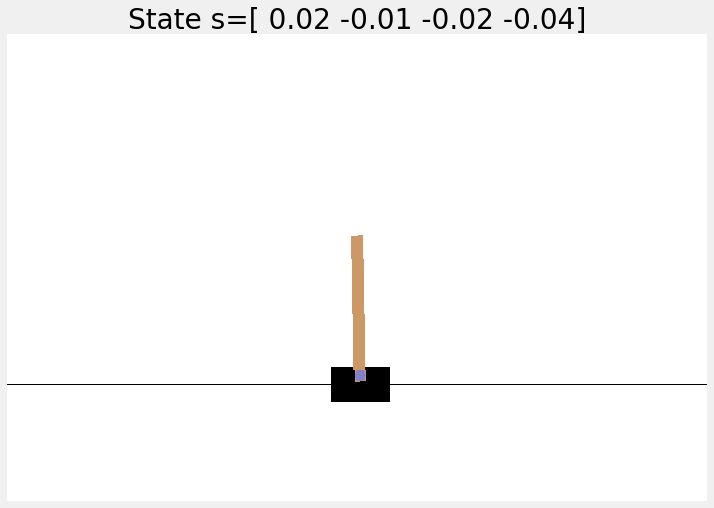

In [25]:
plt.imshow(img)
plt.axis('off')
plt.title("State s=" + str(np.round(state,2)))
plt.show()

In [26]:
q_values = dueling_ddqn_agents[best_dueling_ddqn_agent_key].online_model(state).detach().cpu().numpy()[0]
print(q_values)

[4847684.5 4841260. ]


In [27]:
q_s = q_values
v_s = q_values.mean()
a_s = q_values - q_values.mean()

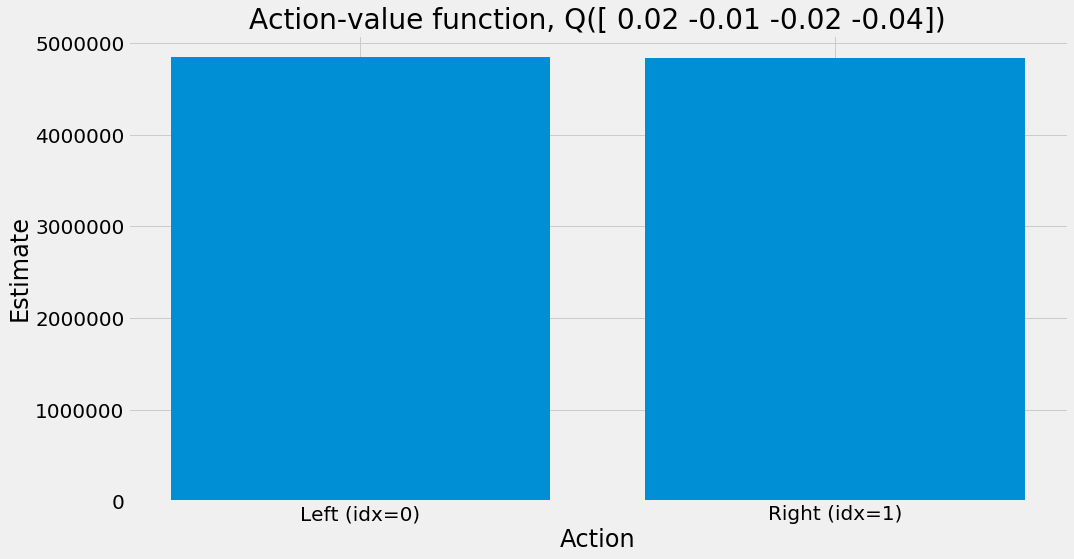

In [28]:
plt.bar(('Left (idx=0)','Right (idx=1)'), q_s)
plt.xlabel('Action')
plt.ylabel('Estimate')
plt.title("Action-value function, Q(" + str(np.round(state,2)) + ")")
plt.show()

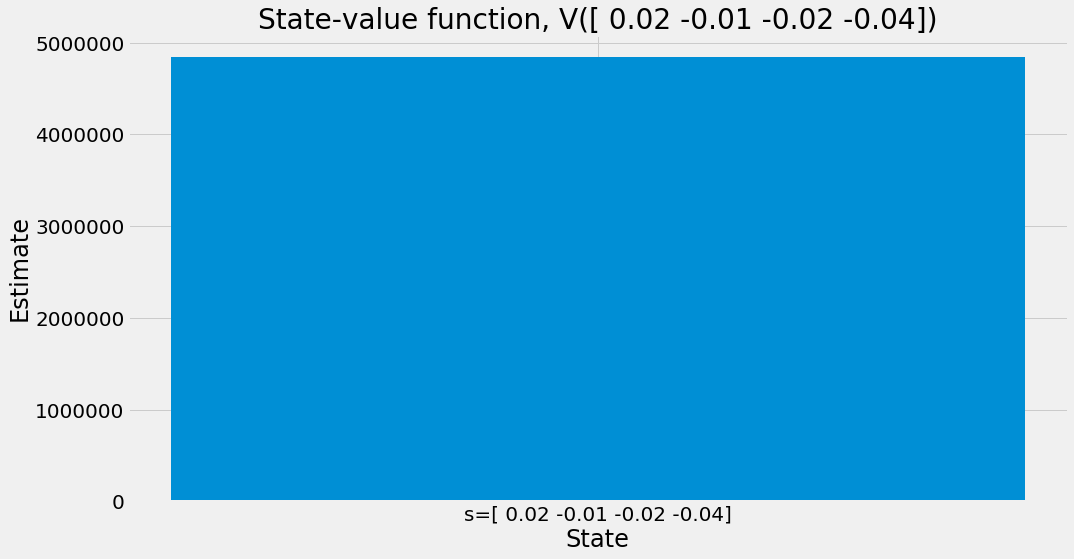

In [29]:
plt.bar('s='+str(np.round(state,2)), v_s, width=0.1)
plt.xlabel('State')
plt.ylabel('Estimate')
plt.title("State-value function, V("+str(np.round(state,2))+")")
plt.show()

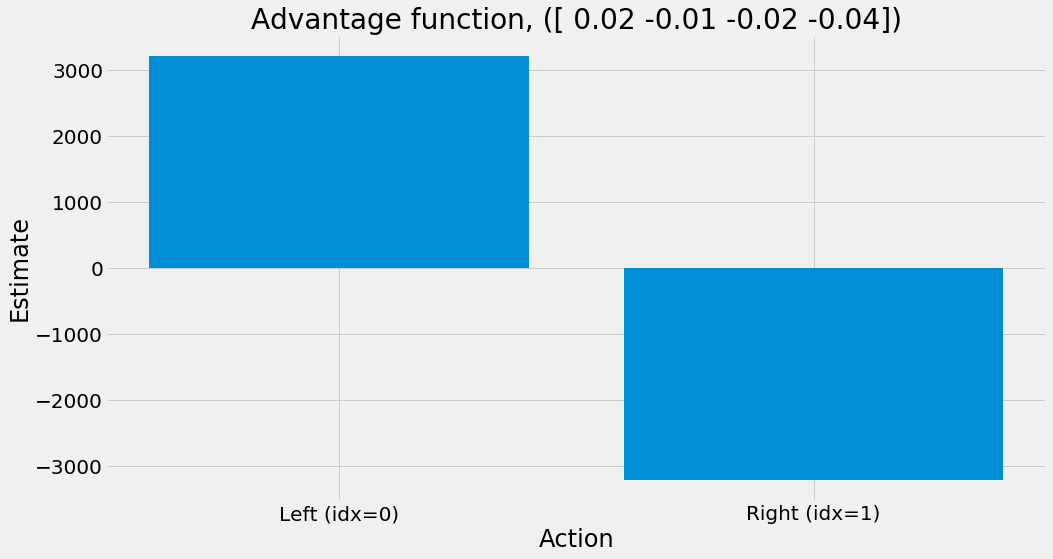

In [30]:
plt.bar(('Left (idx=0)','Right (idx=1)'), a_s)
plt.xlabel('Action')
plt.ylabel('Estimate')
plt.title("Advantage function, (" + str(np.round(state,2)) + ")")
plt.show()

In [31]:
env = make_env_fn(**make_env_kargs, seed=123, monitor_mode='evaluation')

state, states, imgs, t = env.reset(), [], [], False
while not t:
    states.append(state)
    state, r, t, _ = env.step(0)
    imgs.append(env.render(mode='rgb_array'))

env.close()
del env

In [32]:
states[-2]

array([-0.09048686, -1.57504301,  0.13510693,  2.34025535])

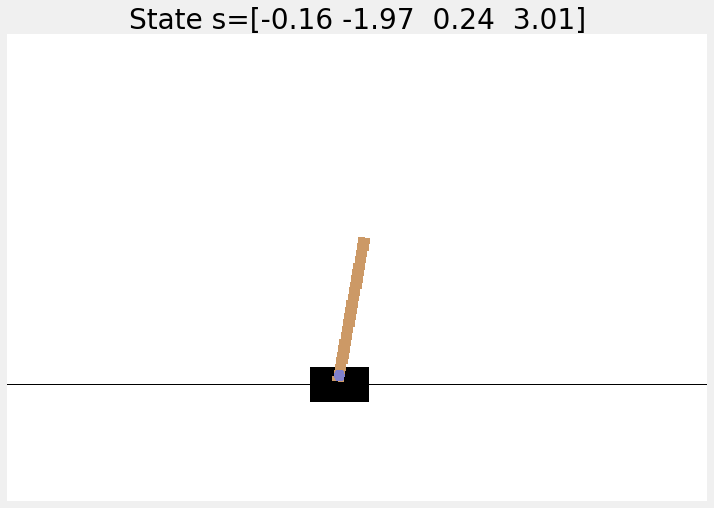

In [33]:
plt.imshow(imgs[-2])
plt.axis('off')
plt.title("State s=" + str(np.round(state,2)))
plt.show()

In [34]:
q_values = dueling_ddqn_agents[best_dueling_ddqn_agent_key].online_model(state).detach().cpu().numpy()[0]
print(q_values)

[2676237.  2960064.8]


In [35]:
q_s = q_values
v_s = q_values.mean()
a_s = q_values - q_values.mean()

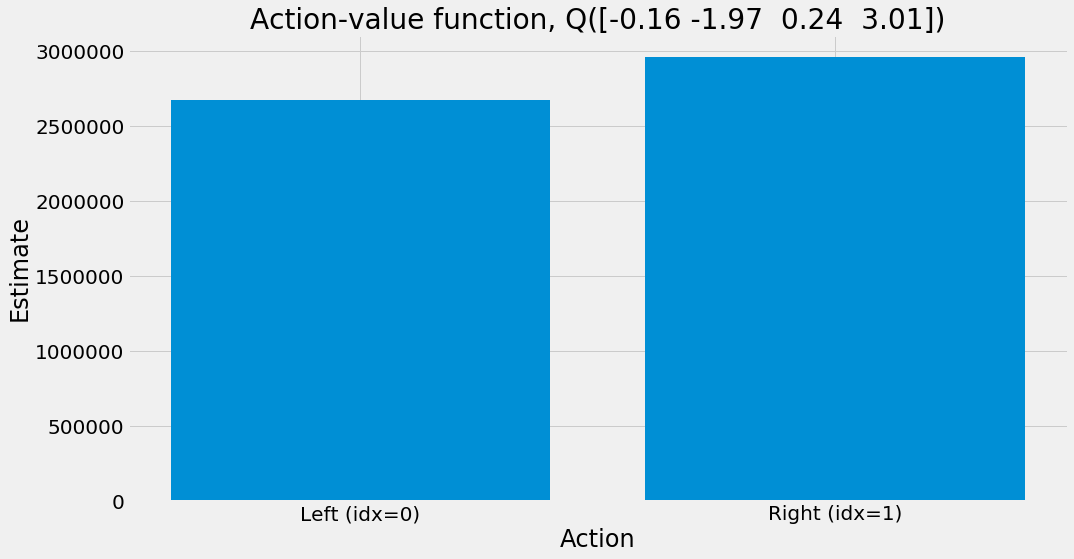

In [36]:
plt.bar(('Left (idx=0)','Right (idx=1)'), q_s)
plt.xlabel('Action')
plt.ylabel('Estimate')
plt.title("Action-value function, Q(" + str(np.round(state,2)) + ")")
plt.show()

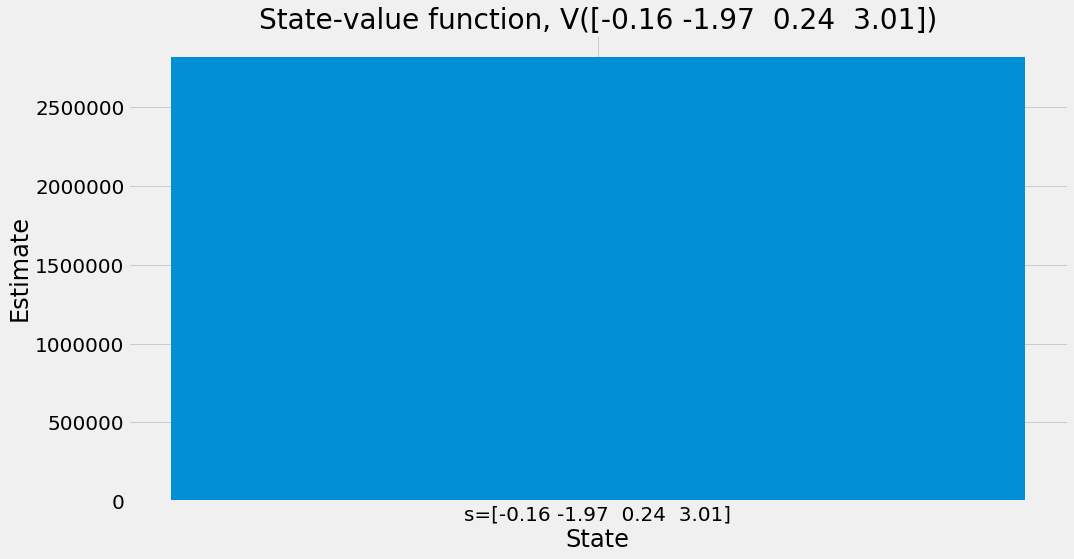

In [37]:
plt.bar('s='+str(np.round(state,2)), v_s, width=0.1)
plt.xlabel('State')
plt.ylabel('Estimate')
plt.title("State-value function, V("+str(np.round(state,2))+")")
plt.show()

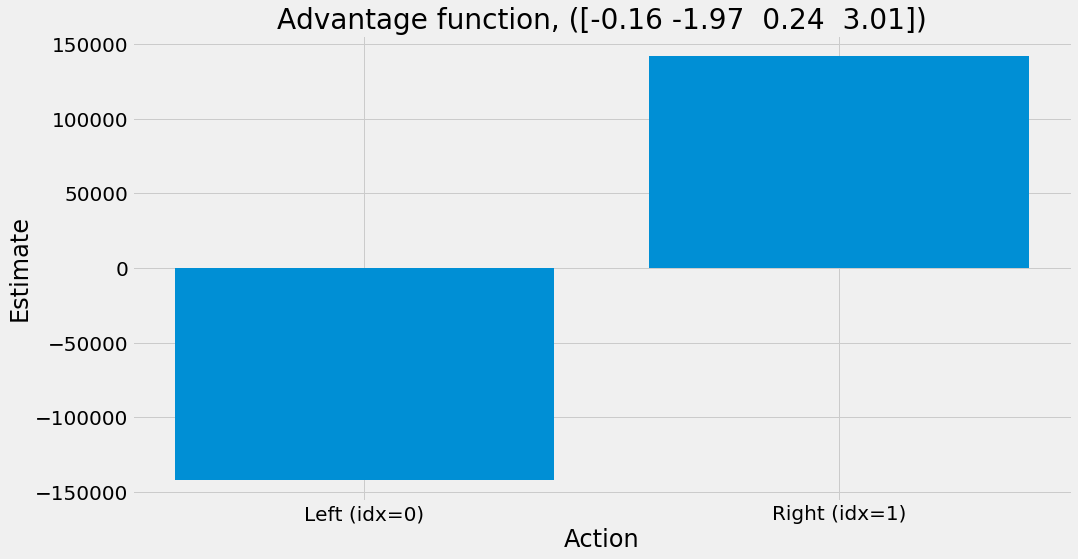

In [38]:
plt.bar(('Left (idx=0)','Right (idx=1)'), a_s)
plt.xlabel('Action')
plt.ylabel('Estimate')
plt.title("Advantage function, (" + str(np.round(state,2)) + ")")
plt.show()

In [39]:
env = make_env_fn(**make_env_kargs, seed=123, monitor_mode='evaluation')

states = []
for agent in dueling_ddqn_agents.values():
    for episode in range(100):
        state, done = env.reset(), False
        while not done:
            states.append(state)
            action = agent.evaluation_strategy.select_action(agent.online_model, state)
            state, _, done, _ = env.step(action)
env.close()
del env

x = np.array(states)[:,0]
xd = np.array(states)[:,1]
a = np.array(states)[:,2]
ad = np.array(states)[:,3]

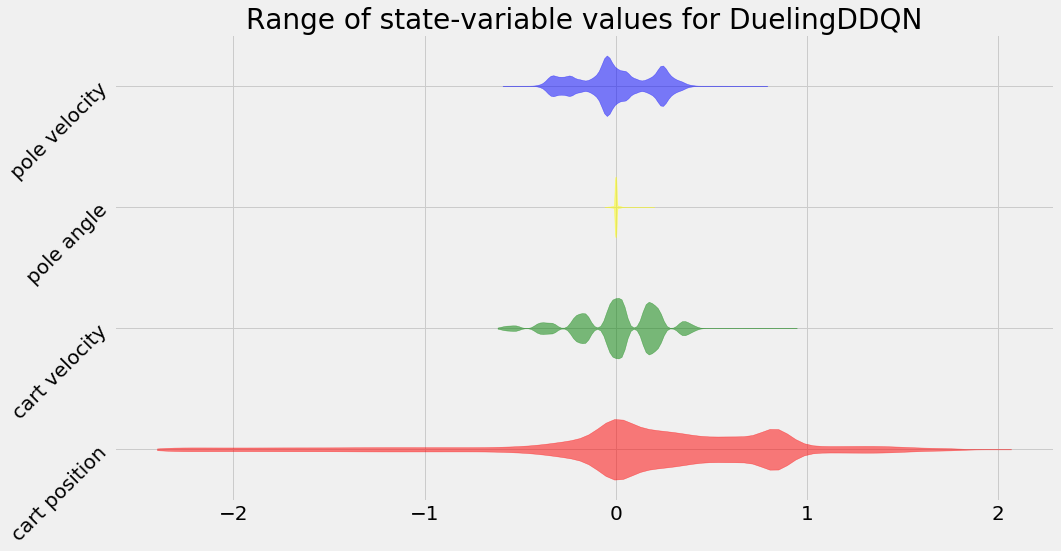

In [40]:
parts = plt.violinplot((x, xd, a, ad), 
                       vert=False, showmeans=False, showmedians=False, showextrema=False)

colors = ['red','green','yellow','blue']
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor(colors[i])
    pc.set_alpha(0.5)

plt.yticks(range(1,5), ["cart position", "cart velocity", "pole angle", "pole velocity"])
plt.yticks(rotation=45)
plt.title('Range of state-variable values for ' + str(
    dueling_ddqn_agents[best_dueling_ddqn_agent_key].__class__.__name__))

plt.show()

## PER

In [41]:
class PrioritizedReplayBuffer():
    def __init__(self, 
                 max_samples=10000, 
                 batch_size=64, 
                 rank_based=False,
                 alpha=0.6, 
                 beta0=0.1, 
                 beta_rate=0.99992):
        self.max_samples = max_samples
        self.memory = np.empty(shape=(self.max_samples, 2), dtype=np.ndarray)
        self.batch_size = batch_size
        self.n_entries = 0
        self.next_index = 0
        self.td_error_index = 0
        self.sample_index = 1
        self.rank_based = rank_based # if not rank_based, then proportional
        self.alpha = alpha # how much prioritization to use 0 is uniform (no priority), 1 is full priority
        self.beta = beta0 # bias correction 0 is no correction 1 is full correction
        self.beta0 = beta0 # beta0 is just beta's initial value
        self.beta_rate = beta_rate

    def update(self, idxs, td_errors):
        self.memory[idxs, self.td_error_index] = np.abs(td_errors)
        if self.rank_based:
            sorted_arg = self.memory[:self.n_entries, self.td_error_index].argsort()[::-1]
            self.memory[:self.n_entries] = self.memory[sorted_arg]

    def store(self, sample):
        priority = 1.0
        if self.n_entries > 0:
            priority = self.memory[
                :self.n_entries, 
                self.td_error_index].max()
        self.memory[self.next_index, 
                    self.td_error_index] = priority
        self.memory[self.next_index, 
                    self.sample_index] = np.array(sample)
        self.n_entries = min(self.n_entries + 1, self.max_samples)
        self.next_index += 1
        self.next_index = self.next_index % self.max_samples

    def _update_beta(self):
        self.beta = min(1.0, self.beta * self.beta_rate**-1)
        return self.beta

    def sample(self, batch_size=None):
        batch_size = self.batch_size if batch_size == None else batch_size
        self._update_beta()
        entries = self.memory[:self.n_entries]

        if self.rank_based:
            priorities = 1/(np.arange(self.n_entries) + 1)
        else: # proportional
            priorities = entries[:, self.td_error_index] + EPS
        scaled_priorities = priorities**self.alpha        
        probs = np.array(scaled_priorities/np.sum(scaled_priorities), dtype=np.float64)

        weights = (self.n_entries * probs)**-self.beta
        normalized_weights = weights/weights.max()
        idxs = np.random.choice(self.n_entries, batch_size, replace=False, p=probs)
        samples = np.array([entries[idx] for idx in idxs])
        
        samples_stacks = [np.vstack(batch_type) for batch_type in np.vstack(samples[:, self.sample_index]).T]
        idxs_stack = np.vstack(idxs)
        weights_stack = np.vstack(normalized_weights[idxs])
        return idxs_stack, weights_stack, samples_stacks

    def __len__(self):
        return self.n_entries
    
    def __repr__(self):
        return str(self.memory[:self.n_entries])
    
    def __str__(self):
        return str(self.memory[:self.n_entries])

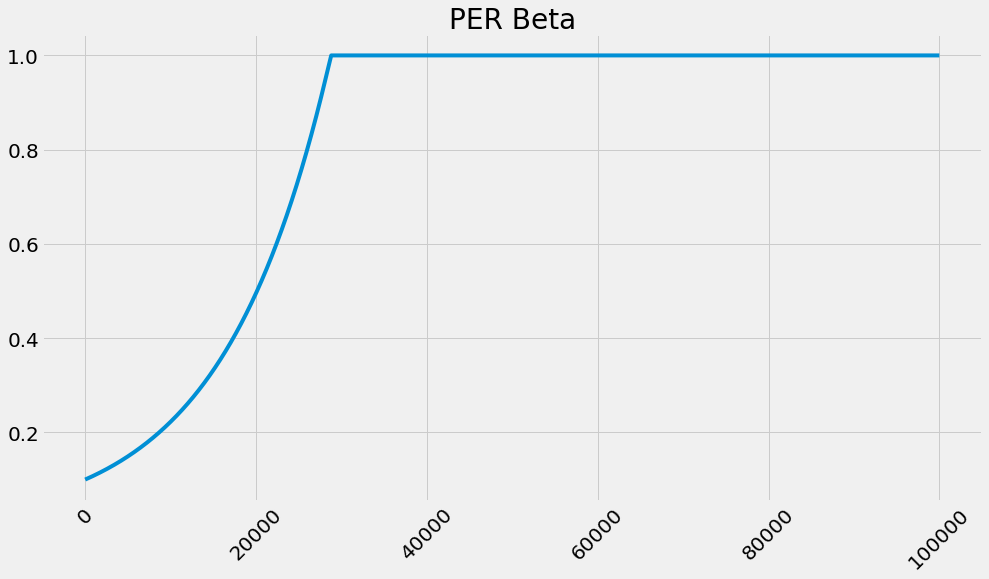

In [42]:
b = PrioritizedReplayBuffer()
plt.plot([b._update_beta() for _ in range(100000)])
plt.title('PER Beta')
plt.xticks(rotation=45)
plt.show()

In [43]:
class PER():
    def __init__(self, 
                 replay_buffer_fn, 
                 value_model_fn, 
                 value_optimizer_fn, 
                 value_optimizer_lr,
                 max_gradient_norm,
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps,
                 tau):
        self.replay_buffer_fn = replay_buffer_fn
        self.value_model_fn = value_model_fn
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        self.max_gradient_norm = max_gradient_norm
        self.training_strategy_fn = training_strategy_fn
        self.evaluation_strategy_fn = evaluation_strategy_fn
        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps
        self.tau = tau

    def optimize_model(self, experiences):
        idxs, weights, \
        (states, actions, rewards, next_states, is_terminals) = experiences
        weights = self.online_model.numpy_float_to_device(weights)
        batch_size = len(is_terminals)
        
        argmax_a_q_sp = self.online_model(next_states).max(1)[1]
        q_sp = self.target_model(next_states).detach()
        max_a_q_sp = q_sp[
            np.arange(batch_size), argmax_a_q_sp].unsqueeze(1)
        target_q_sa = rewards + (self.gamma * max_a_q_sp * (1 - is_terminals))
        q_sa = self.online_model(states).gather(1, actions)

        td_error = q_sa - target_q_sa
        value_loss = (weights * td_error).pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()        
        torch.nn.utils.clip_grad_norm_(self.online_model.parameters(), 
                                       self.max_gradient_norm)
        self.value_optimizer.step()

        priorities = np.abs(td_error.detach().cpu().numpy())
        self.replay_buffer.update(idxs, priorities)

    def interaction_step(self, state, env):
        action = self.training_strategy.select_action(self.online_model, state)
        new_state, reward, is_terminal, info = env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_terminal and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))

        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.training_strategy.exploratory_action_taken)
        return new_state, is_terminal
    
    def update_network(self, tau=None):
        tau = self.tau if tau is None else tau
        for target, online in zip(self.target_model.parameters(), 
                                  self.online_model.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.checkpoint_dir = tempfile.mkdtemp()
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        self.target_model = self.value_model_fn(nS, nA)
        self.online_model = self.value_model_fn(nS, nA)
        self.update_network(tau=1.0)

        self.value_optimizer = self.value_optimizer_fn(self.online_model, 
                                                       self.value_optimizer_lr)

        self.replay_buffer = self.replay_buffer_fn()
        self.training_strategy = training_strategy_fn()
        self.evaluation_strategy = evaluation_strategy_fn() 
                    
        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state, env)
                
                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    idxs, weights, samples = experiences
                    experiences = self.online_model.load(samples)
                    experiences = (idxs, weights) + (experiences,)
                    self.optimize_model(experiences)
                
                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_network()

                if is_terminal:
                    gc.collect()
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.online_model, env)
            self.save_checkpoint(episode-1, self.online_model)

            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)
            
            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward

            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:06}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
                
        final_eval_score, score_std = self.evaluate(self.online_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        self.get_cleaned_checkpoints()
        return result, final_eval_score, training_time, wallclock_time
    
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.evaluation_strategy.select_action(eval_policy_model, s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)

    def get_cleaned_checkpoints(self, n_checkpoints=5):
        try: 
            return self.checkpoint_paths
        except AttributeError:
            self.checkpoint_paths = {}

        paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
        paths_dic = {int(path.split('.')[-2]):path for path in paths}
        last_ep = max(paths_dic.keys())
        # checkpoint_idxs = np.geomspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1
        checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1

        for idx, path in paths_dic.items():
            if idx in checkpoint_idxs:
                self.checkpoint_paths[idx] = path
            else:
                os.unlink(path)

        return self.checkpoint_paths

    def demo_last(self, title='Fully-trained {} Agent', n_episodes=3, max_n_videos=3):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        last_ep = max(checkpoint_paths.keys())
        self.online_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

        self.evaluate(self.online_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def demo_progression(self, title='{} Agent progression', max_n_videos=5):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        for i in sorted(checkpoint_paths.keys()):
            self.online_model.load_state_dict(torch.load(checkpoint_paths[i]))
            self.evaluate(self.online_model, env, n_episodes=1)

        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            subtitle_eps=sorted(checkpoint_paths.keys()),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(), 
                   os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))

In [44]:
per_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 30,
        'max_episodes': 10000,
        'goal_mean_100_reward': 475
    }

    value_model_fn = lambda nS, nA: FCDuelingQ(nS, nA, hidden_dims=(512,128))
    value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0001
    max_gradient_norm = float('inf')

    training_strategy_fn = lambda: EGreedyExpStrategy(init_epsilon=1.0,  
                                                      min_epsilon=0.3, 
                                                      decay_steps=20000)
    evaluation_strategy_fn = lambda: GreedyStrategy()

    # replay_buffer_fn = lambda: ReplayBuffer(max_size=10000, batch_size=64)
    # replay_buffer_fn = lambda: PrioritizedReplayBuffer(
    #     max_samples=10000, batch_size=64, rank_based=True, 
    #     alpha=0.6, beta0=0.1, beta_rate=0.99995)
    replay_buffer_fn = lambda: PrioritizedReplayBuffer(
        max_samples=20000, batch_size=64, rank_based=False,
        alpha=0.6, beta0=0.1, beta_rate=0.99995)
    n_warmup_batches = 5
    update_target_every_steps = 1
    tau = 0.01

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = PER(replay_buffer_fn, 
                value_model_fn, 
                value_optimizer_fn, 
                value_optimizer_lr,
                max_gradient_norm,
                training_strategy_fn,
                evaluation_strategy_fn,
                n_warmup_batches,
                update_target_every_steps,
                tau)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    per_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
per_results = np.array(per_results)
_ = BEEP()

el 00:00:00, ep 0000, ts 000016, ar 10 016.0±000.0, 100 016.0±000.0, ex 100 0.3±0.0, ev 009.0±000.0
el 00:02:00, ep 0127, ts 009088, ar 10 242.3±066.6, 100 084.0±086.0, ex 100 0.4±0.1, ev 260.4±117.1
el 00:04:02, ep 0161, ts 017625, ar 10 250.1±033.7, 100 159.5±107.3, ex 100 0.3±0.1, ev 315.6±078.8
el 00:06:04, ep 0192, ts 025241, ar 10 224.2±046.9, 100 218.6±088.9, ex 100 0.2±0.1, ev 303.7±071.9
el 00:08:06, ep 0219, ts 032721, ar 10 281.3±108.5, 100 256.4±071.7, ex 100 0.2±0.0, ev 302.8±058.6
el 00:10:09, ep 0241, ts 040416, ar 10 374.4±120.5, 100 278.2±086.1, ex 100 0.2±0.0, ev 331.0±083.0
el 00:12:14, ep 0259, ts 048142, ar 10 445.8±111.4, 100 310.5±114.6, ex 100 0.2±0.0, ev 362.1±098.9
el 00:14:20, ep 0277, ts 056257, ar 10 449.6±118.2, 100 346.9±125.4, ex 100 0.2±0.0, ev 400.6±100.6
el 00:16:26, ep 0300, ts 064241, ar 10 324.6±186.5, 100 368.5±140.5, ex 100 0.2±0.0, ev 448.8±081.7
el 00:17:51, ep 0314, ts 069724, ar 10 414.0±100.9, 100 384.4±136.8, ex 100 0.2±0.0, ev 475.8±057.0



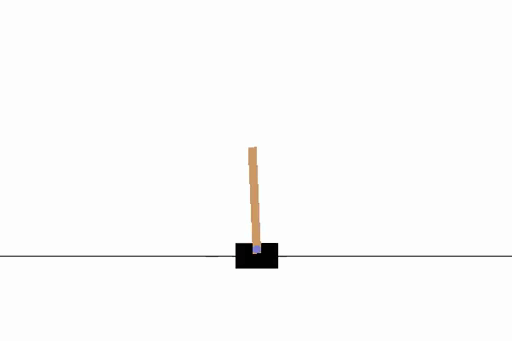
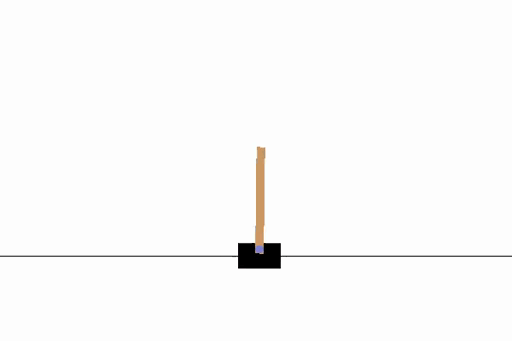
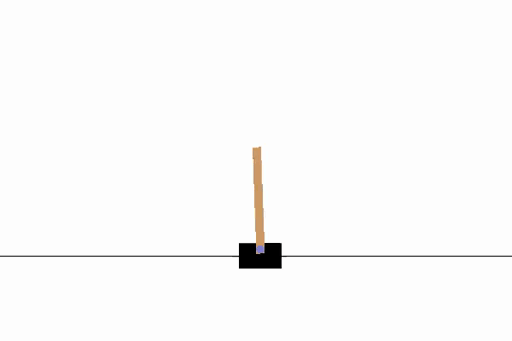
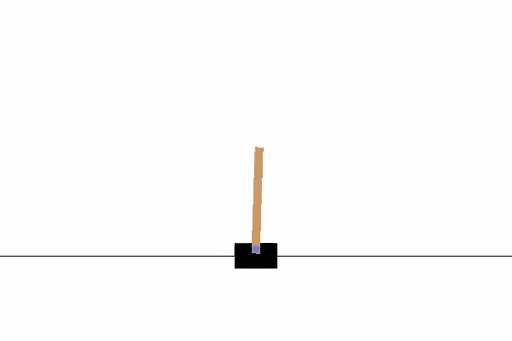
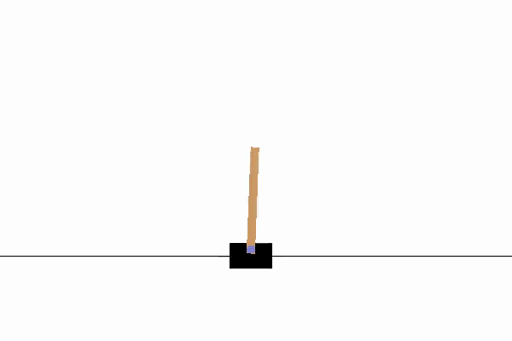

In [45]:
best_agent.demo_progression()


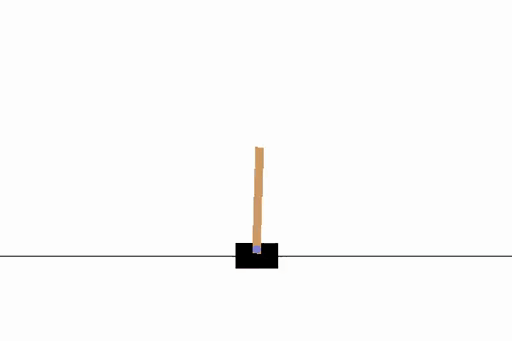
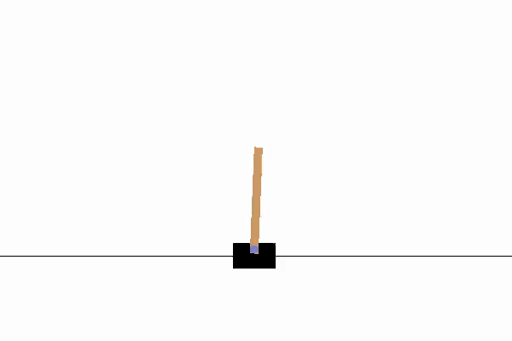
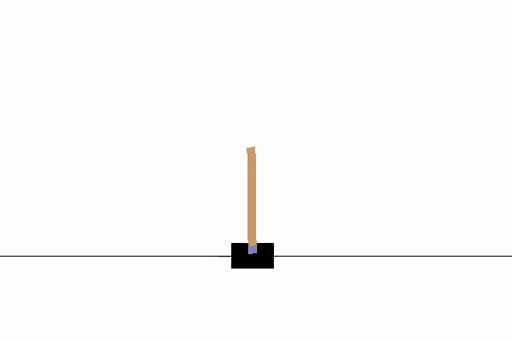

In [46]:
best_agent.demo_last()

In [47]:
per_max_t, per_max_r, per_max_s, per_max_sec, per_max_rt = np.max(per_results, axis=0).T
per_min_t, per_min_r, per_min_s, per_min_sec, per_min_rt = np.min(per_results, axis=0).T
per_mean_t, per_mean_r, per_mean_s, per_mean_sec, per_mean_rt = np.mean(per_results, axis=0).T
per_x = np.arange(np.max(
    (len(per_mean_s), len(dueling_ddqn_mean_s))))

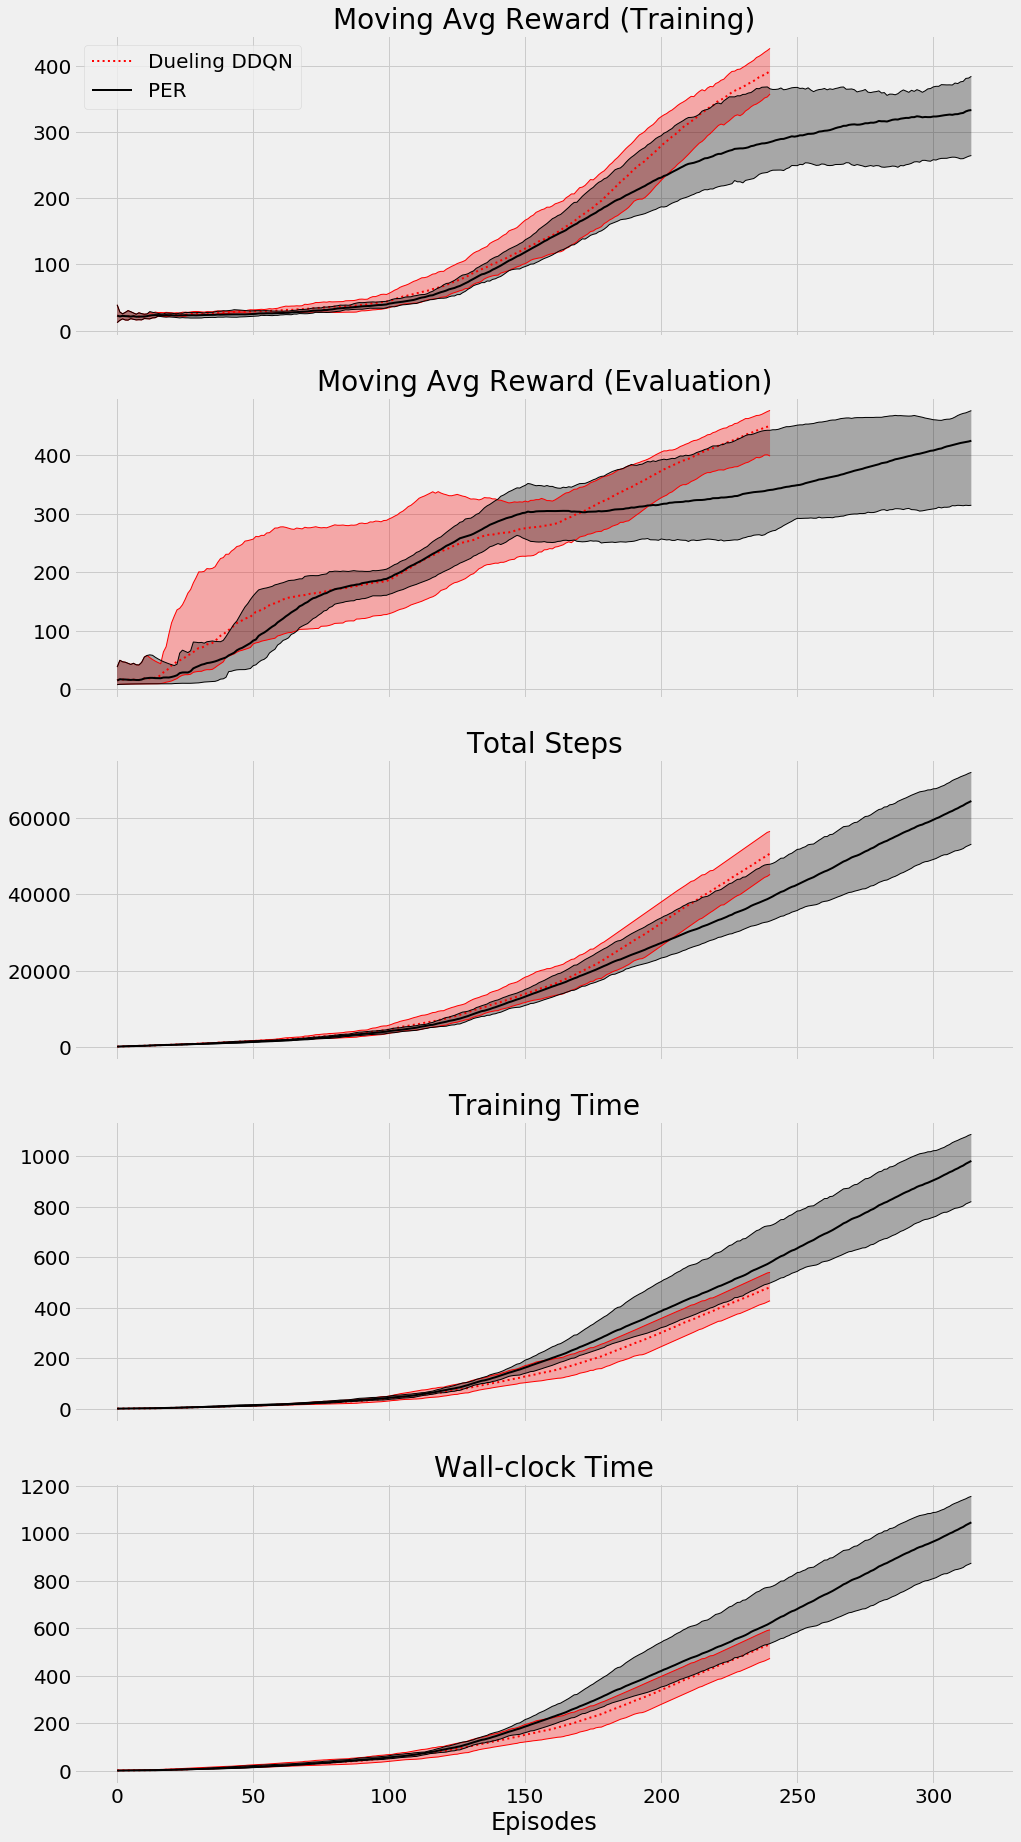

In [48]:
fig, axs = plt.subplots(5, 1, figsize=(15,30), sharey=False, sharex=True)

# Dueling DDQN
axs[0].plot(dueling_ddqn_max_r, 'r', linewidth=1)
axs[0].plot(dueling_ddqn_min_r, 'r', linewidth=1)
axs[0].plot(dueling_ddqn_mean_r, 'r:', label='Dueling DDQN', linewidth=2)
axs[0].fill_between(
    dueling_ddqn_x, dueling_ddqn_min_r, dueling_ddqn_max_r, facecolor='r', alpha=0.3)

axs[1].plot(dueling_ddqn_max_s, 'r', linewidth=1)
axs[1].plot(dueling_ddqn_min_s, 'r', linewidth=1)
axs[1].plot(dueling_ddqn_mean_s, 'r:', label='Dueling DDQN', linewidth=2)
axs[1].fill_between(
    dueling_ddqn_x, dueling_ddqn_min_s, dueling_ddqn_max_s, facecolor='r', alpha=0.3)

axs[2].plot(dueling_ddqn_max_t, 'r', linewidth=1)
axs[2].plot(dueling_ddqn_min_t, 'r', linewidth=1)
axs[2].plot(dueling_ddqn_mean_t, 'r:', label='Dueling DDQN', linewidth=2)
axs[2].fill_between(
    dueling_ddqn_x, dueling_ddqn_min_t, dueling_ddqn_max_t, facecolor='r', alpha=0.3)

axs[3].plot(dueling_ddqn_max_sec, 'r', linewidth=1)
axs[3].plot(dueling_ddqn_min_sec, 'r', linewidth=1)
axs[3].plot(dueling_ddqn_mean_sec, 'r:', label='Dueling DDQN', linewidth=2)
axs[3].fill_between(
    dueling_ddqn_x, dueling_ddqn_min_sec, dueling_ddqn_max_sec, facecolor='r', alpha=0.3)

axs[4].plot(dueling_ddqn_max_rt, 'r', linewidth=1)
axs[4].plot(dueling_ddqn_min_rt, 'r', linewidth=1)
axs[4].plot(dueling_ddqn_mean_rt, 'r:', label='Dueling DDQN', linewidth=2)
axs[4].fill_between(
    dueling_ddqn_x, dueling_ddqn_min_rt, dueling_ddqn_max_rt, facecolor='r', alpha=0.3)

# PER
axs[0].plot(per_max_r, 'k', linewidth=1)
axs[0].plot(per_min_r, 'k', linewidth=1)
axs[0].plot(per_mean_r, 'k', label='PER', linewidth=2)
axs[0].fill_between(per_x, per_min_r, per_max_r, facecolor='k', alpha=0.3)

axs[1].plot(per_max_s, 'k', linewidth=1)
axs[1].plot(per_min_s, 'k', linewidth=1)
axs[1].plot(per_mean_s, 'k', label='PER', linewidth=2)
axs[1].fill_between(per_x, per_min_s, per_max_s, facecolor='k', alpha=0.3)

axs[2].plot(per_max_t, 'k', linewidth=1)
axs[2].plot(per_min_t, 'k', linewidth=1)
axs[2].plot(per_mean_t, 'k', label='PER', linewidth=2)
axs[2].fill_between(per_x, per_min_t, per_max_t, facecolor='k', alpha=0.3)

axs[3].plot(per_max_sec, 'k', linewidth=1)
axs[3].plot(per_min_sec, 'k', linewidth=1)
axs[3].plot(per_mean_sec, 'k', label='PER', linewidth=2)
axs[3].fill_between(per_x, per_min_sec, per_max_sec, facecolor='k', alpha=0.3)

axs[4].plot(per_max_rt, 'k', linewidth=1)
axs[4].plot(per_min_rt, 'k', linewidth=1)
axs[4].plot(per_mean_rt, 'k', label='PER', linewidth=2)
axs[4].fill_between(per_x, per_min_rt, per_max_rt, facecolor='k', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [49]:
per_root_dir = os.path.join(RESULTS_DIR, 'per')
not os.path.exists(per_root_dir) and os.makedirs(per_root_dir)

np.save(os.path.join(per_root_dir, 'x'), per_x)

np.save(os.path.join(per_root_dir, 'max_r'), per_max_r)
np.save(os.path.join(per_root_dir, 'min_r'), per_min_r)
np.save(os.path.join(per_root_dir, 'mean_r'), per_mean_r)

np.save(os.path.join(per_root_dir, 'max_s'), per_max_s)
np.save(os.path.join(per_root_dir, 'min_s'), per_min_s )
np.save(os.path.join(per_root_dir, 'mean_s'), per_mean_s)

np.save(os.path.join(per_root_dir, 'max_t'), per_max_t)
np.save(os.path.join(per_root_dir, 'min_t'), per_min_t)
np.save(os.path.join(per_root_dir, 'mean_t'), per_mean_t)

np.save(os.path.join(per_root_dir, 'max_sec'), per_max_sec)
np.save(os.path.join(per_root_dir, 'min_sec'), per_min_sec)
np.save(os.path.join(per_root_dir, 'mean_sec'), per_mean_sec)

np.save(os.path.join(per_root_dir, 'max_rt'), per_max_rt)
np.save(os.path.join(per_root_dir, 'min_rt'), per_min_rt)
np.save(os.path.join(per_root_dir, 'mean_rt'), per_mean_rt)